In [1]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU
from tensorflow.keras import regularizers

In [2]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [3]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
1591  Non_HS  Anjing itu melompati pagar dengan lincah untuk...
2362      HS                  Bacot, gaya sama otak timpang doi
1769      HS  Tangkap Ahok sekarang juga, koruptor reklamasi...
1478  Non_HS                  Anjing itu mendengkur saat tidur.
2555      HS  Brengsek itu bukan di liat dari ganteng/cantik...


       Label                                              Tweet
517   Non_HS  sentiasa ingatkan diri jangan selalu tunjukkan...
2471      HS                          0 kata buat lo!! BAJINGAN
3379      HS  Mampus lu bangsat. Di cuekin ibu ibu.. ngabisi...
1083  Non_HS  hari ini aku belajar sesuatu aku belajar untuk...
3008      HS  RATU PELAKOR SEJAGAT RAYA, DIMANA2 LONTE YA GA...


In [5]:
data['Label'].value_counts()

HS        1722
Non_HS    1688
Name: Label, dtype: int64

In [6]:
def parse_data(data):
    labels = []
    tweets = []

    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])

    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [7]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 3410 examples

2nd example:
Bacot, gaya sama otak timpang doi

Last example:
RATU PELAKOR SEJAGAT RAYA, DIMANA2 LONTE YA GAK PUNYA MALU. yang NGERASA LONTE DISINI TOLONG PUNYA MALU DIKIT


In [8]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]

    return train_labels, train_tweets, test_labels, test_tweets

In [9]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 3069 sentences for training.
 3069 labels for training.
 341 sentences for validation.
 341 labels for validation.


In [10]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['Anjing itu melompati pagar dengan lincah untuk mengejar bola yang dilemparkan.', 'Bacot, gaya sama otak timpang doi', 'Tangkap Ahok sekarang juga, koruptor reklamasi Jakarta dan penista Agama Islam.']
[1, 0, 0]
['Terlalu anjing untuk di ingat, terlalu bangsat untuk dikenang, terlalu sampah untuk merindu. Aku wes ora peduli ~', 'Dan soal soal ribut-ribut pribumi vs non pribumi yang ramai di beranda saya itu, sebenarnya maksudnya apa? ikut...', 'cewe itu gak selama nya bisa sabar ngadepin kelakukan bajingan laki-laki']
[0, 1, 0]


In [11]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [12]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [13]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 8392 words

<OOV> token included in vocabulary


In [14]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [15]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3069, 120)

Padded validation sequences have shape: (341, 120)


In [16]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [17]:
print(type(test_labels))

<class 'list'>


In [18]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[  4   9 677 ...   0   0   0]
 [152 452  18 ...   0   0   0]
 [  1   8 303 ...   0   0   0]
 ...
 [  1   1   6 ...   0   0   0]
 [105 328   7 ...   0   0   0]
 [  1   1 359 ...   0   0   0]]


[[484   4  23 ...   0   0   0]
 [  5 891 891 ...   0   0   0]
 [387   9  28 ...   0   0   0]
 ...
 [877  45  39 ...   0   0   0]
 [ 83  10   2 ...   0   0   0]
 [  1   1   1 ...   0   0   0]]
[0 1 0 1 1 0 1 0 1 1]


In [19]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[1 0 0 ... 1 1 0]


In [20]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [21]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[1 0 0 ... 1 1 0]


[0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1
 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1
 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0
 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1
 0 0 0 1 0 0 1 0]


[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.

In [22]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_1 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 3s 11ms/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.5044
Epoch 2/30
96/96 [==============================] - 1s 9ms/step - loss: 0.6915 - accuracy: 0.5585 - val_loss: 0.6898 - val_accuracy: 0.5044
Epoch 3/30
96/96 [==============================] - 1s 11ms/step - loss: 0.6838 - accuracy: 0.6272 - val_loss: 0.6747 - val_accuracy: 0.6422
Epoch 4/30
96/96 [==============================] - 1s 11ms/step - loss: 0.6487 - accuracy: 0.7374 - val_loss: 0.6219 - val_accuracy: 0.8211
Epoch 5/30
96/96 [==============================] - 1s 7ms/step - loss: 0.5704 - accuracy: 0.8289 - val_loss: 0.5335 - val_accuracy: 0.8270
Epoch 6/30
96/96 [==============================] - 1s 6ms/step - loss: 0.4738 - accuracy: 0.8517 - val_loss: 0.4611 - val_accuracy: 0.8152
Epoch 7/30
96/96 [==============================] - 1s 6ms/step - loss: 0.4013 - accuracy: 0.8615 - val_loss: 0.4093 - val_accuracy: 0.8446
Epoch 8/30
96/96 

In [23]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.55920756 0.4407924 ]]


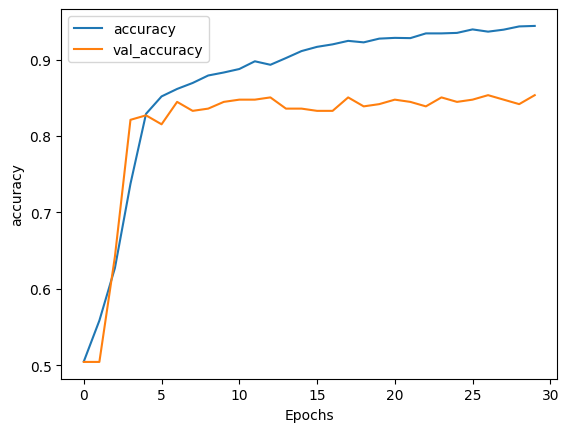

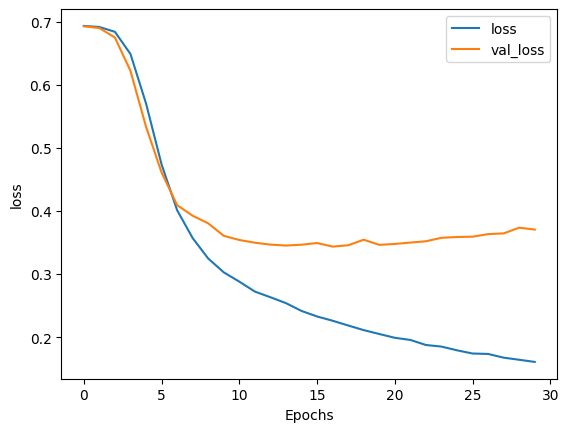

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [25]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 33s 211ms/step - loss: 0.6934 - accuracy: 0.4858 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/30
96/96 [==============================] - 17s 180ms/step - loss: 0.6909 - accuracy: 0.5207 - val_loss: 0.6276 - val_accuracy: 0.7537
Epoch 3/30
96/96 [==============================] - 18s 191ms/step - loss: 0.4487 - accuracy: 0.8211 - val_loss: 0.4335 - val_accuracy: 0.8299
Epoch 4/30
96/96 [==============================] - 18s 192ms/step - loss: 0.3586 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8651
Epoch 5/30
96/96 [==============================] - 21s 221ms/step - loss: 0.3094 - accuracy: 0.8912 - val_loss: 0.3688 - val_accuracy: 0.8563
Epoch 6/30
96/96 [==============================] - 17s 180ms/step - loss: 0.3267 - accuracy: 0.8579 - val_loss: 0.4133 - val_accuracy: 0.8358
Epoch 7/30
96/96 [==============================] - 19s 196ms/step - loss: 0.3150 - accuracy: 0.8814 - val_loss: 0.4280 - val_accuracy: 0.8387

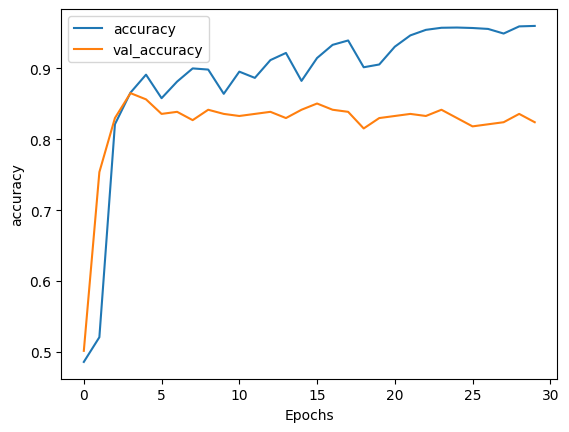

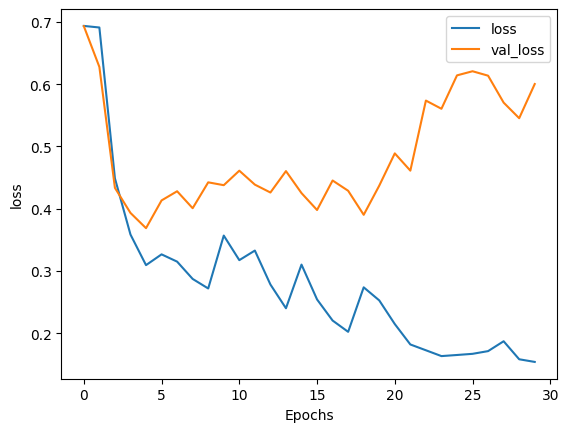

In [33]:
plot_graphs(history_LSTM, "accuracy")
plot_graphs(history_LSTM, "loss")

In [27]:
# Definisikan callback function
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Dapatkan learning rate berdasarkan epoch saat ini
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Panggil fungsi schedule untuk mendapatkan learning rate baru
        scheduled_lr = self.schedule(epoch, lr)
        # Atur learning rate pada optimizer
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch + 1}: Learning rate set to {scheduled_lr}")

# Fungsi untuk mengatur schedule learning rate
def learning_rate_schedule(epoch, lr):
    # Learning rate akan berkurang setiap 5 epoch
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.1  # Mengurangi learning rate menjadi 10% dari sebelumnya
    return lr

In [29]:
# Compile model
# Adam Opt
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat instance dari LearningRateScheduler
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Latih model dengan menggunakan callback LearningRateScheduler
history_LSTM_1 = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30,
                              validation_data=(val_padded_seq, test_labels_one_hot),
                              callbacks=[lr_scheduler])


Epoch 1: Learning rate set to 0.0010000000474974513
Epoch 1/30
96/96 [==============================] - 40s 203ms/step - loss: 0.1592 - accuracy: 0.9550 - val_loss: 0.4848 - val_accuracy: 0.8328

Epoch 2: Learning rate set to 0.0010000000474974513
Epoch 2/30
96/96 [==============================] - 17s 174ms/step - loss: 0.1446 - accuracy: 0.9573 - val_loss: 0.5116 - val_accuracy: 0.8446

Epoch 3: Learning rate set to 0.0010000000474974513
Epoch 3/30
96/96 [==============================] - 18s 187ms/step - loss: 0.1392 - accuracy: 0.9612 - val_loss: 0.5163 - val_accuracy: 0.8387

Epoch 4: Learning rate set to 0.0010000000474974513
Epoch 4/30
96/96 [==============================] - 17s 173ms/step - loss: 0.1218 - accuracy: 0.9658 - val_loss: 0.5491 - val_accuracy: 0.8475

Epoch 5: Learning rate set to 0.0010000000474974513
Epoch 5/30
96/96 [==============================] - 18s 192ms/step - loss: 0.1228 - accuracy: 0.9681 - val_loss: 0.5175 - val_accuracy: 0.8504

Epoch 6: Learning r

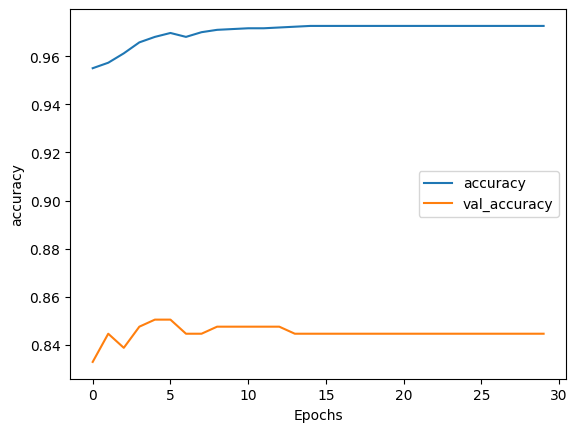

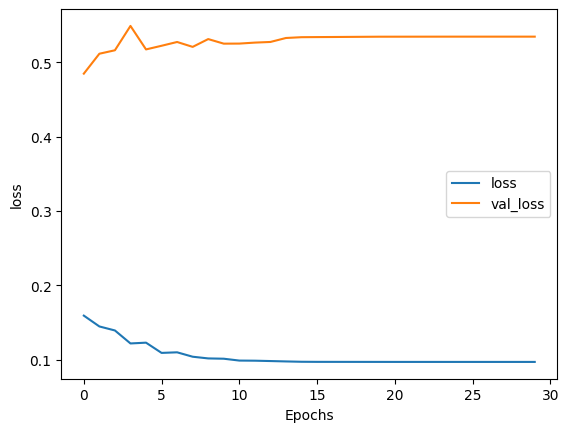

In [34]:
# plotting dengan callback function
plot_graphs(history_LSTM_1, "accuracy")
plot_graphs(history_LSTM_1, "loss")

In [30]:
model.save('model.h5')

In [31]:
# Load model Keras dari file .h5
model = tf.keras.models.load_model('model.h5')

# Inisialisasi TFLiteConverter dengan model Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konversi model menjadi format TFLite
tflite_model = converter.convert()

In [32]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)